In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# if torch.cuda.is_available:
#     dev = 'cuda:0'
#     torch.backends.cudnn.benchmark = True
# else:
#     dev = 'cpu'
dev = 'cpu'
print(dev)

cpu


### Loading Data

In [6]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [7]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [8]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### Exercise 2: Fixed MLP with Increasing Training Dataset

Create a MLP with one hidden layer with 200 units for Fashion MNIST classification. Use ReLU activation.

Use a random fraction of the training set (split above) to perform the training. Always use the same validation set.

Use SGD and cross-entropy loss and suitable learning rate.

Start with a single small batch for training (batch size 8) and make sure that you can overfit, i.e. bring the training accuracy to 100%.

Then, gradually increase the training set. Let it grow until you obtain values for the training and the validation loss which no longer indicate overfitting. Use a fixed batch size (batchsize 32).

#### MLP Class

In [9]:
# define a method that provides an instance of an MLP which uses as a list of units per layer as input


def mlp(units=[28 * 28, 200, 10]):
    """
    Creates an instance of an MLP with layers as specified in the 'units'-list (list of integers).
    """
    modules = []
    modules.append(torch.nn.Flatten())
    for i in range(len(units)-2):
        modules.append(torch.nn.Linear(units[i], units[i+1]))
        modules.append(torch.nn.ReLU())
    modules.append(torch.nn.Linear(units[-2], units[-1]))
    model = torch.nn.Sequential(*modules)
    return model

    # YOUR CODE HERE #

In [10]:
# create an instance and its summary
model = mlp()
from torchsummary import summary
summary(model, (1,28,28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
            Linear-4                   [-1, 10]           2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.61
Estimated Total Size (MB): 0.62
----------------------------------------------------------------


#### Training Loop 

In [11]:
def train_eval(model, lr, nepochs, nbatch, training_data, validation_data, verbose=True):
    """
    Performs the training of a model with given learning rate (lr), 
    number of epochs (nepochs), batchsize (nbatch) and training and validation data.
    Suitable data loaders are instantiated for the training and validation datasets.
    Keep book about cost and accuracy (per epoch) for both training and validation set.
    """
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []


    # YOUR CODE HERE #
    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    test_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)

    nbatches_train = len(training_loader)
    nbatches_test = len(test_loader)
    size_train = len(training_loader.dataset)
    size_test = len(test_loader.dataset)


    for epoch in range(nepochs):
        acc = 0.0
        cost = 0.0
        for X,Y in training_loader:
            X = X.to(dev)
            Y = Y.to(dev)
            pred = model(X)
            loss = cost_ce(pred, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cost += cost_ce(pred, Y).item()
            acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

        cost /= nbatches_train
        acc /= size_train
        
        cost_hist.append(cost)
        acc_hist.append(acc)

        acc_test = 0.0
        cost_test = 0.0
        with torch.no_grad():
            for X,Y in test_loader:
                X = X.to(dev)
                Y = Y.to(dev)
                pred = model(X)
                cost_test += cost_ce(pred, Y).item()
                acc_test += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
        cost_test /= nbatches_test
        acc_test /= size_test
                
        cost_hist_test.append(cost_test)
        acc_hist_test.append(acc_test)
    
        if verbose:
            print(f"Epoch {epoch}: {cost}, {acc}, {cost_test}, {acc_test}")
    
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

#### First Training

Run a first training with only one small training batch (e.g. with a single batch of 64 samples). 
The small training set can be created by using the functionality `torch.utils.data.random_split` already used above. As validation set use the `validation_data` created above.  

This training run can be used to test whether the model and training loop are properly implemented. Explain why and in what sense it can be used as test.

This is something you can always do when training a model.

32 49968
Epoch 0: 2.2978906631469727, 0.09375, 2.2660804571815953, 0.1598
Epoch 1: 2.177626848220825, 0.375, 2.2427401009459085, 0.1486
Epoch 2: 2.0718533992767334, 0.34375, 2.223768962457919, 0.1459
Epoch 3: 1.9710478782653809, 0.34375, 2.204870726353825, 0.1682
Epoch 4: 1.8727689981460571, 0.4375, 2.18064307214353, 0.2195
Epoch 5: 1.7792104482650757, 0.46875, 2.1472889188760385, 0.2662
Epoch 6: 1.6916567087173462, 0.5, 2.109121770904468, 0.2791
Epoch 7: 1.610069751739502, 0.5, 2.0661863465659533, 0.2855
Epoch 8: 1.5328097343444824, 0.5, 2.023689511484993, 0.294
Epoch 9: 1.4608150720596313, 0.5, 1.9838574149738104, 0.3062
Epoch 10: 1.394264578819275, 0.5625, 1.945802887026875, 0.3206
Epoch 11: 1.3319857120513916, 0.5625, 1.9104270706542383, 0.3407
Epoch 12: 1.2741947174072266, 0.59375, 1.874623187052937, 0.3618
Epoch 13: 1.2202469110488892, 0.625, 1.8413521184707984, 0.3804
Epoch 14: 1.1697250604629517, 0.65625, 1.8096053314666016, 0.3932
Epoch 15: 1.1221883296966553, 0.6875, 1.779867

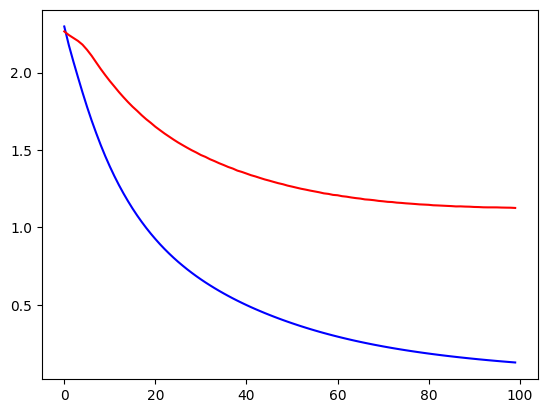

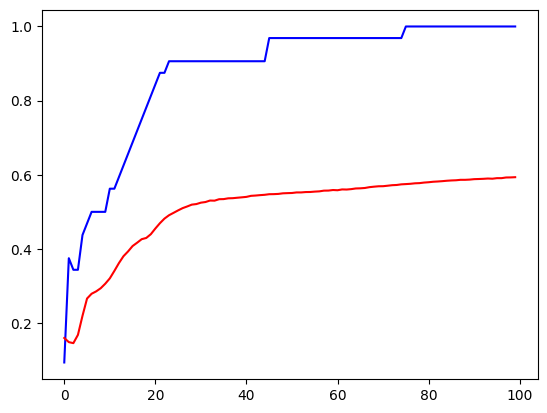

In [12]:
nbatch = 32
nbatches = 1
nepochs = 100
lr = 0.1

trainsize = nbatches*nbatch
trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])
print(len(trainset), len(rest))

model = mlp([28*28, 200, 10])
model.to(dev)
cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data)

plt.figure(1)
plt.plot(range(nepochs), cost_train, "b-")
plt.plot(range(nepochs), cost_valid, "r-")

plt.figure(2)
plt.plot(range(nepochs), acc_train, "b-")
plt.plot(range(nepochs), acc_valid, "r-")

#### Evaluate Train and Validation Performance 

Now run several trainings with the same small model (one hidden layer) and explore for different number of training samples (different number of batches with 32 samples) used, how the train and validation performance evolve (cost and accuracy). Make sure that you train sufficiently long to obtain representative values for cost and accuracy with the given settings. Always use the same validation set (with 10'000 samples).

Create plots with training and validation performance vs number of training batches (one for cost and one for accuracy). Use the performance characteristics obtained at the end.

Discuss the whether there is a sufficient number of training samples for the given problem at hand. Specify a minimum number if applicable. Also consider whether you are in the underfitting regime.

Hint: Specify a list with the number of training batches you would like to perform trainings. Try to be economic with the resources used - try to keep the number of trainings limited.

In [21]:
cost_train_list = []
cost_valid_list = []
acc_train_list = []
acc_valid_list = []
nbatches_list = [2,10,100,1000,int(50000/32)]
for nbatches in nbatches_list:
    nbatch = 32
    nepochs = 100
    lr = 0.1

    trainsize = nbatches*nbatch
    trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])
    print(len(trainset), len(rest))

    model = mlp([28*28, 200, 10]).to(dev)
    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data, verbose=False)
    cost_train_list.append(cost_train[-1])
    cost_valid_list.append(cost_valid[-1])
    acc_train_list.append(acc_train[-1])
    acc_valid_list.append(acc_valid[-1])

    print(f"Run with {nbatches} batches complete")

64 49936
Run with 2 batches complete
320 49680
Run with 10 batches complete
3200 46800
Run with 100 batches complete
32000 18000
Run with 1000 batches complete
49984 16
Run with 1562 batches complete


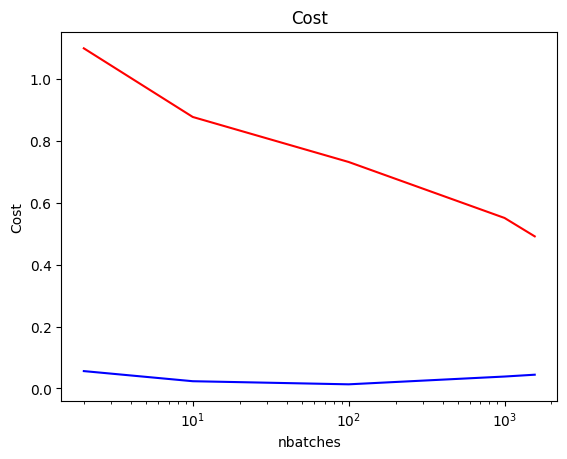

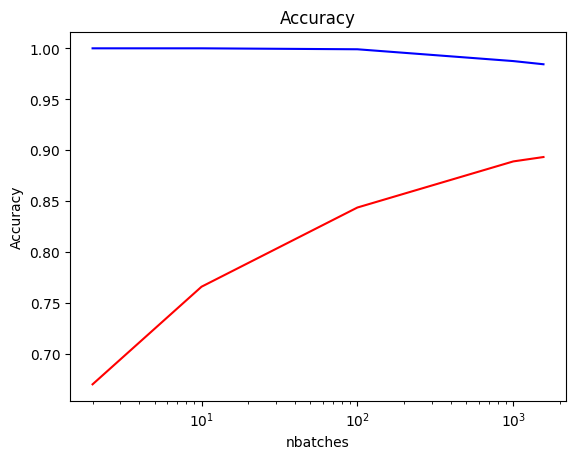

In [25]:
plt.figure(1)
plt.plot(nbatches_list, cost_train_list, "b-")
plt.plot(nbatches_list, cost_valid_list, "r-")
plt.title("Cost")
plt.xlabel("nbatches")
plt.ylabel("Cost")
plt.xscale('log')

plt.figure(2)
plt.plot(nbatches_list, acc_train_list, "b-")
plt.plot(nbatches_list, acc_valid_list, "r-")
plt.title("Accuracy")
plt.xlabel("nbatches")
plt.ylabel("Accuracy")
plt.xscale('log')

#### Comments:
- The training accuracy get close to 100% even for all data. This means underfitting is not the problem here.
- The validation accuarcy stays way below the training accuracy meaning that the model does still overfit, even with all samples in training.
However the overfitting gets less severe with more training samples.

### Exercise 3: Evaluate Different Model Complexities

Use the same functionality implemented above (create MLP model, train and evaluate model) to evaluate different model complexities: Number of layers and number of units per layer.

Start with the small model used in Exercise 2. Then gradually increase the model complexity. Do this along two dimensions:
* a single hidden layer, but increasing the number of units.
* a fixed number of units per (hidden) layer, but increase the number of layers.
Make sure that you reach the overfitting regime (in either case).

Always use the full training set with 50'000 samples.

Again make sure that you train sufficiently long so that the obtained train and validation performance measures (cost, accuracy) are representative.

Create plots with training and validation performance (cost, accuracy) vs model complexity - one plot with number of units for the single hidden layer case, and one for varying number of layers. 

Again use the performance characteristics obtained at the end. 

Finally, discuss your findings.

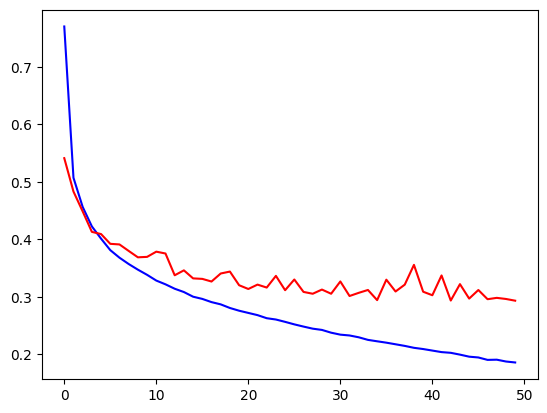

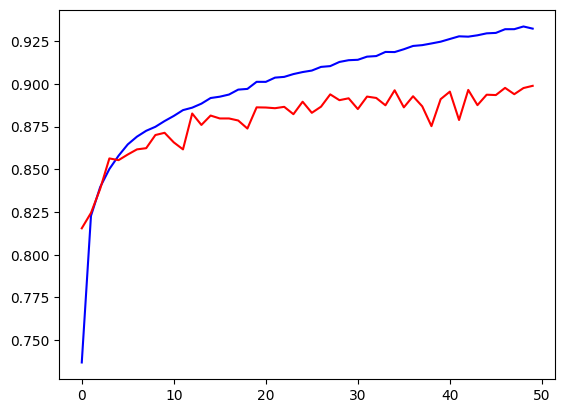

Run with 200 units complete


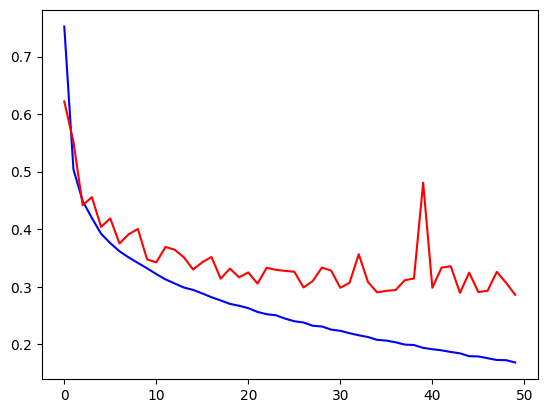

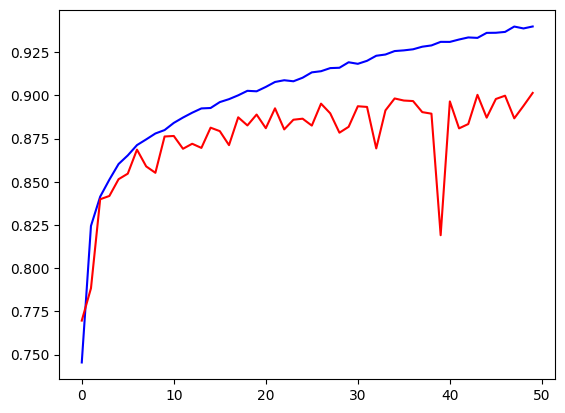

Run with 400 units complete


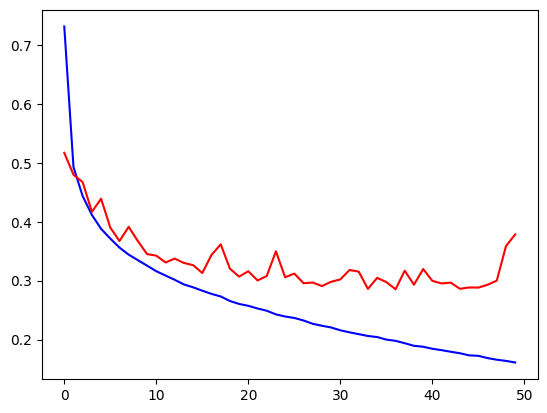

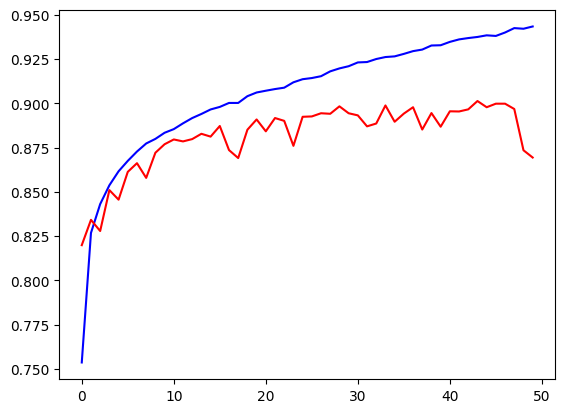

Run with 800 units complete


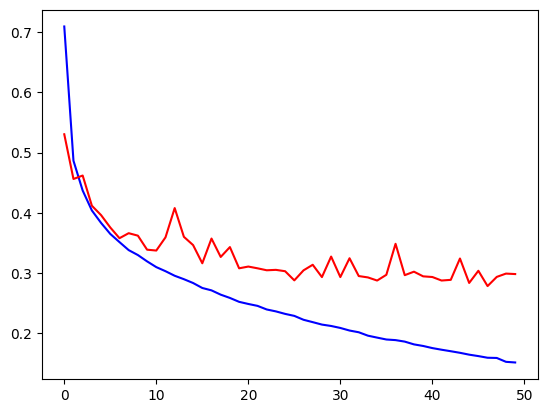

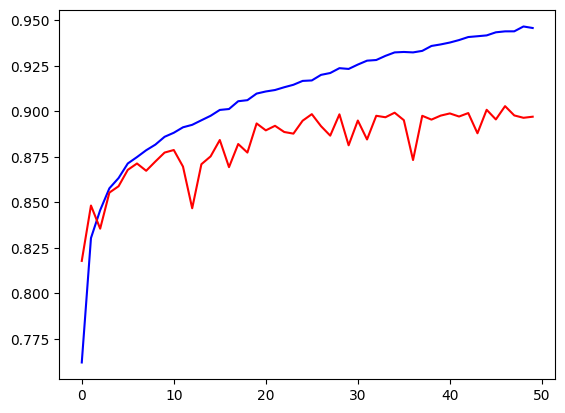

Run with 1600 units complete


In [18]:
# YOUR CODE HERE #
# several iterations with the code snippets of the form:

cost_train_list_units = []
cost_valid_list_units = []
acc_train_list_units = []
acc_valid_list_units = []
nrs_units = [200, 400, 800, 1600]

for nr_units in nrs_units:
    nbatch = 128
    nepochs = 50
    lr = 0.1


    model = mlp([28*28, nr_units, 10]).to(dev)
    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, training_data, validation_data, verbose=False)
    cost_train_list_units.append(cost_train[-1])
    cost_valid_list_units.append(cost_valid[-1])
    acc_train_list_units.append(acc_train[-1])
    acc_valid_list_units.append(acc_valid[-1])

    plt.figure(1)
    plt.plot(range(nepochs), cost_train, "b-")
    plt.plot(range(nepochs), cost_valid, "r-")

    plt.figure(2)
    plt.plot(range(nepochs), acc_train, "b-")
    plt.plot(range(nepochs), acc_valid, "r-")
    plt.show()

    print(f"Run with {nr_units} units complete")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                   [-1, 10]           1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


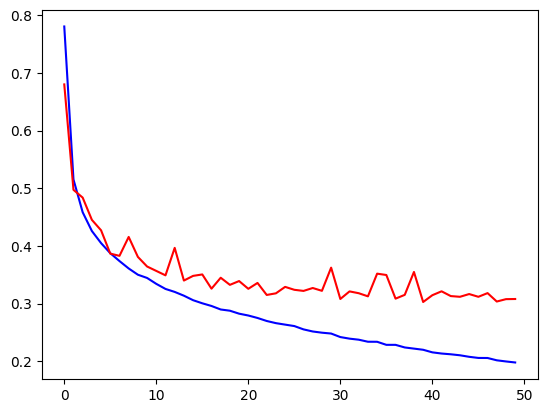

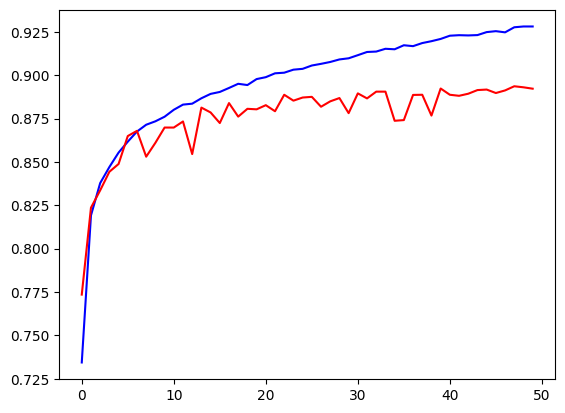

Run with 1 layers complete
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 10]           1,010
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.34
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


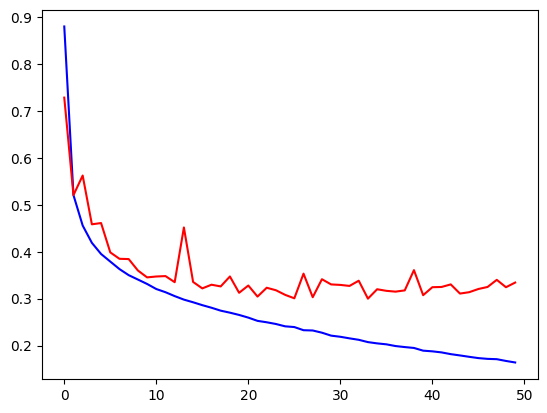

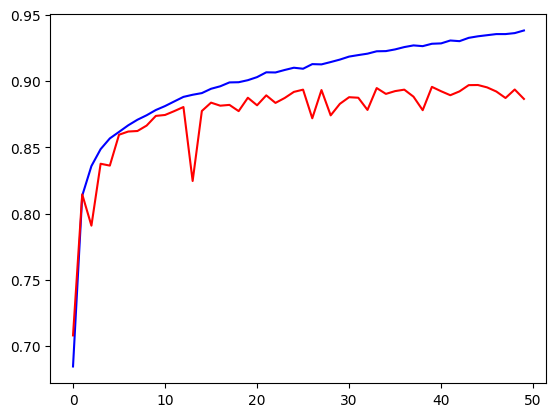

Run with 2 layers complete
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
              ReLU-5                  [-1, 100]               0
            Linear-6                  [-1, 100]          10,100
              ReLU-7                  [-1, 100]               0
            Linear-8                  [-1, 100]          10,100
              ReLU-9                  [-1, 100]               0
           Linear-10                  [-1, 100]          10,100
             ReLU-11                  [-1, 100]               0
           Linear-12                   [-1, 10]           1,010
Total params: 119,910
Trainable params: 119,910
Non-trainable params: 0
----

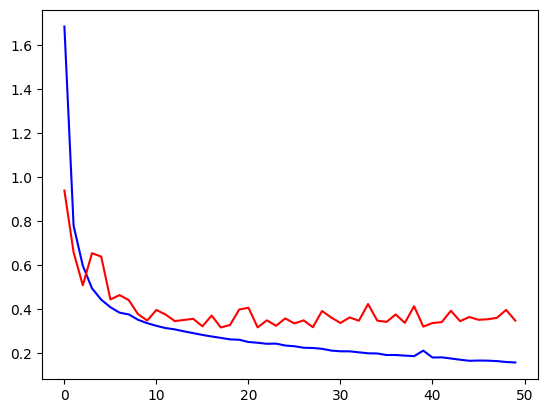

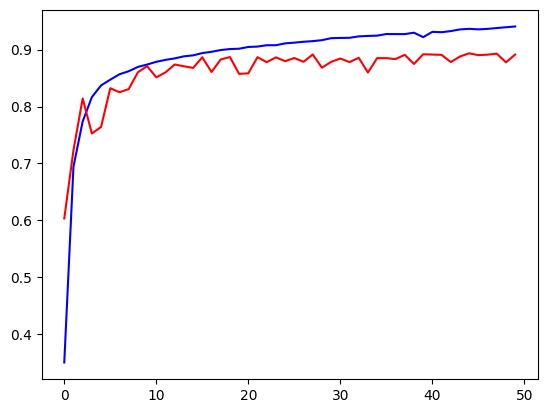

Run with 5 layers complete
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
              ReLU-5                  [-1, 100]               0
            Linear-6                  [-1, 100]          10,100
              ReLU-7                  [-1, 100]               0
            Linear-8                  [-1, 100]          10,100
              ReLU-9                  [-1, 100]               0
           Linear-10                  [-1, 100]          10,100
             ReLU-11                  [-1, 100]               0
           Linear-12                  [-1, 100]          10,100
             ReLU-13                  [-1, 100]               0
           L

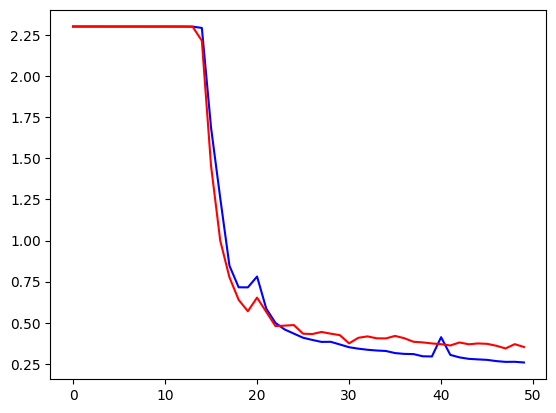

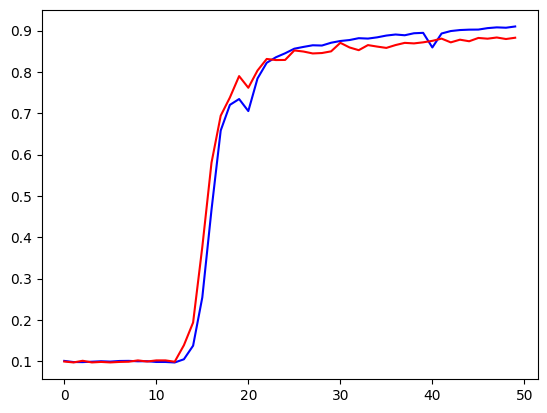

Run with 10 layers complete


In [20]:

cost_train_list_layers = []
cost_valid_list_layers = []
acc_train_list_layers = []
acc_valid_list_layers = []
nrs_layers = [1,2,5,10]
for nr_layers in nrs_layers:
    nbatch = 128
    nepochs = 50
    lr = 0.1

    units = [28*28]
    for _ in range(nr_layers):
        units.append(100)
    units.append(10)

    model = mlp(units)
    summary(model, (1,28,28), device='cpu')
    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, training_data, validation_data, verbose=False)
    cost_train_list_layers.append(cost_train[-1])
    cost_valid_list_layers.append(cost_valid[-1])
    acc_train_list_layers.append(acc_train[-1])
    acc_valid_list_layers.append(acc_valid[-1])

    plt.figure(1)
    plt.plot(range(nepochs), cost_train, "b-")
    plt.plot(range(nepochs), cost_valid, "r-")

    plt.figure(2)
    plt.plot(range(nepochs), acc_train, "b-")
    plt.plot(range(nepochs), acc_valid, "r-")
    plt.show()

    print(f"Run with {nr_layers} layers complete")

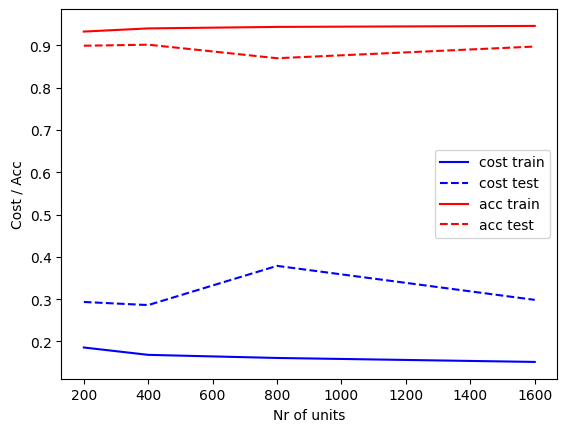

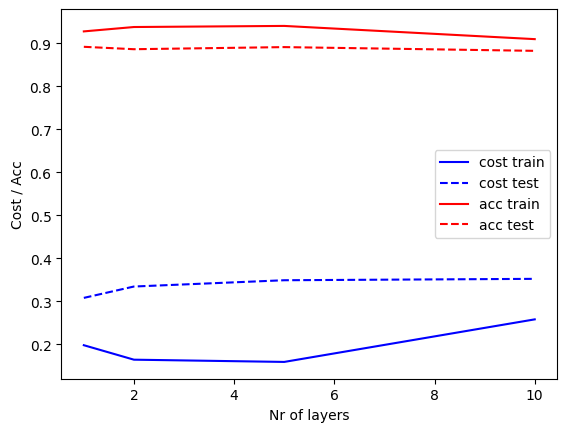

In [21]:
plt.figure(1)
plt.plot(nrs_units, cost_train_list_units, "b-", label = 'cost train')
plt.plot(nrs_units, cost_valid_list_units, "b--", label = 'cost test')
plt.plot(nrs_units, acc_train_list_units, "r-", label = 'acc train')
plt.plot(nrs_units, acc_valid_list_units, "r--", label = 'acc test')
plt.xlabel("Nr of units")
plt.ylabel("Cost / Acc")
plt.legend()

plt.figure(2)
plt.plot(nrs_layers, cost_train_list_layers, "b-", label = 'cost train')
plt.plot(nrs_layers, cost_valid_list_layers, "b--", label = 'cost test')
plt.plot(nrs_layers, acc_train_list_layers, "r-", label = 'acc train')
plt.plot(nrs_layers, acc_valid_list_layers, "r--", label = 'acc test')
plt.xlabel("Nr of layers")
plt.ylabel("Cost / Acc")
plt.legend()

#### Comments: 
- Raising the number of units in a single layer does not seem to improve the problem of overfitting,since the gap in loss and accuracy stays rather consistent in the first graph
- Raising the number of layers however does improve the overfitting. This can be seen in the second graph, where loss and accuracy for training and test samples get closer for 10 layers.

### Exercise 4: Add Regularisation

Finally, add regularisation - dropout or L1/L2-regularisation. 

To this end, you need to implement new functionality to instantiate the model.

Start with one of the overfitting cases of Exercise 3 and try to improve the validation performance by adding regularisation. You can use either dropout or L1/L2-regularisation.


In [24]:
# define a method that provides an instance of an MLP incl regularisation which uses as a list of units per layer as input 

def mlp_dropout(units = [28*28, 200, 10], p_in = 0.2, p_hidden=0.5):
    """
    Creates an instance of an MLP with layers as specified in the 'units'-list (list of integers) and dropout 
    regularisation. Dropout rate for all layers the same except for the first (p_in). For the output layer 
    no dropout applied. 
    """
    modules = []
    modules.append(torch.nn.Flatten())
    modules.append(torch.nn.Dropout(p = p_in))
    for i in range(len(units)-2):
        modules.append(torch.nn.Linear(units[i], units[i+1]))
        modules.append(torch.nn.ReLU())
        modules.append(torch.nn.Dropout(p = p_hidden))
    modules.append(torch.nn.Linear(units[-2], units[-1]))
    model = torch.nn.Sequential(*modules)
    return model
    # YOUR CODE HERE #

    

In [28]:
model = mlp_dropout([28*28,200,10])

from torchsummary import summary
summary(model, (1,28,28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 200]         157,000
              ReLU-4                  [-1, 200]               0
           Dropout-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.61
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


Epoch 0: 2.333737850189209, 0.0625, 2.280819257608237, 0.1288
Epoch 1: 2.2389392852783203, 0.25, 2.2442575575063786, 0.1365
Epoch 2: 2.1726810932159424, 0.25, 2.214630554278438, 0.1511
Epoch 3: 2.1134166717529297, 0.3125, 2.18947530173646, 0.1675
Epoch 4: 2.0717878341674805, 0.1875, 2.1565899856555197, 0.1907
Epoch 5: 2.0452358722686768, 0.4375, 2.129234191327811, 0.2054
Epoch 6: 1.9431813955307007, 0.4375, 2.0990527517879354, 0.2256
Epoch 7: 1.9395488500595093, 0.3125, 2.068015967695096, 0.2489
Epoch 8: 1.918241262435913, 0.25, 2.0257600309749764, 0.2837
Epoch 9: 1.7753393650054932, 0.5, 1.9842662034324183, 0.3064
Epoch 10: 1.7294392585754395, 0.5, 1.9551760499088908, 0.3036
Epoch 11: 1.6555317640304565, 0.5, 1.9159024512044156, 0.327
Epoch 12: 1.7290010452270508, 0.4375, 1.8914248756707286, 0.34
Epoch 13: 1.6581975221633911, 0.59375, 1.8615594835707936, 0.3478
Epoch 14: 1.6193828582763672, 0.4375, 1.8248242551145462, 0.3724
Epoch 15: 1.541387677192688, 0.46875, 1.8037187965533223, 0.

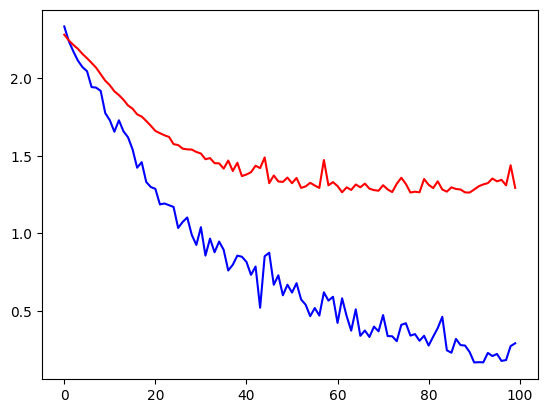

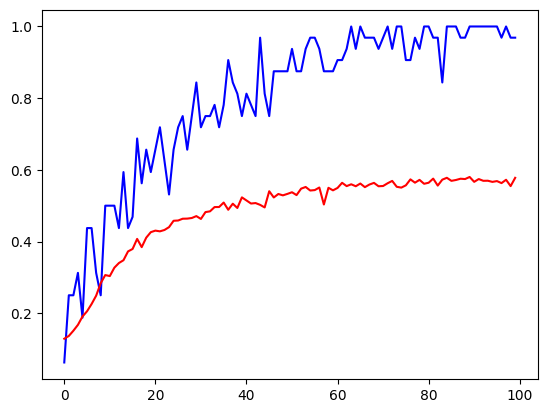

In [54]:
nbatch = 32
nepochs = 100
lr = 0.1

model = mlp_dropout([28*28, 200, 10])
model.to(dev)
cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data)

plt.figure(1)
plt.plot(range(nepochs), cost_train, "b-")
plt.plot(range(nepochs), cost_valid, "r-")

plt.figure(2)
plt.plot(range(nepochs), acc_train, "b-")
plt.plot(range(nepochs), acc_valid, "r-")

#### Playing with different complexities and regularisation

Now play with different complexities and regularisation. 
Start with one of the overfitting cases identified in the previous exercise.
By adding regularisation, you should be able to make it non-overfitting, i.e. generalising better.
Note that for a given complexity, adding regularisation reduces the model capacity. This may need to be compensated by increasing the complexity of the model. 

Use again cost and accuracy for train and validation set to evaluate the results.

Finally, estimate the bias error and the generalisation error. 

Epoch 0: 2.2992029190063477, 0.09375, 2.3032599798025797, 0.1051
Epoch 1: 2.323702573776245, 0.125, 2.303865071683646, 0.1001
Epoch 2: 2.2874560356140137, 0.1875, 2.3035822546901032, 0.1002
Epoch 3: 2.2826671600341797, 0.125, 2.3030292302274855, 0.1009
Epoch 4: 2.2775065898895264, 0.1875, 2.300975946572642, 0.1053
Epoch 5: 2.3055107593536377, 0.03125, 2.299443114679842, 0.107
Epoch 6: 2.2989516258239746, 0.09375, 2.2992223459310805, 0.0996
Epoch 7: 2.263925313949585, 0.15625, 2.2989254310108223, 0.0985
Epoch 8: 2.2743990421295166, 0.21875, 2.2983610028276047, 0.1032
Epoch 9: 2.2749900817871094, 0.09375, 2.2979825335188795, 0.1069
Epoch 10: 2.270963191986084, 0.0625, 2.29595471723392, 0.1127
Epoch 11: 2.2447495460510254, 0.1875, 2.296312169906811, 0.106
Epoch 12: 2.2594146728515625, 0.09375, 2.2970304359643223, 0.1066
Epoch 13: 2.2337827682495117, 0.125, 2.296825657256495, 0.108
Epoch 14: 2.2665727138519287, 0.0625, 2.295664679128141, 0.1058
Epoch 15: 2.2461719512939453, 0.15625, 2.2935

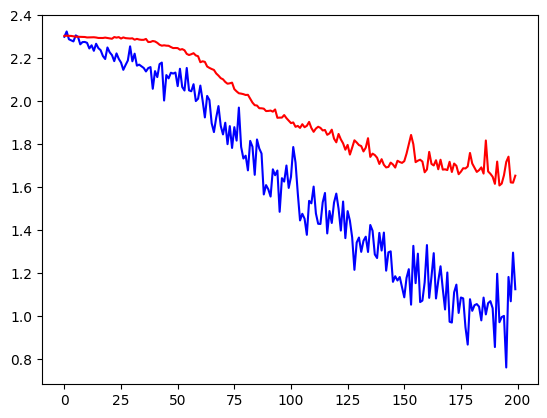

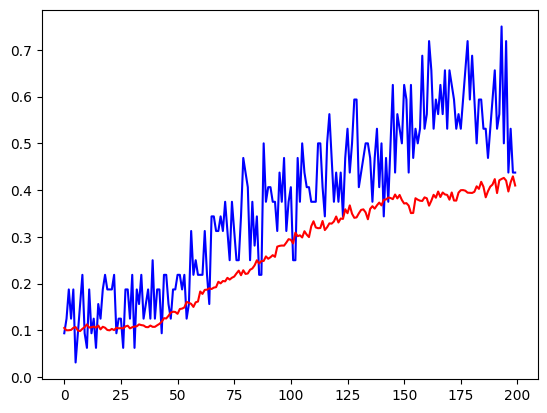

In [55]:
# YOUR CODE HERE #

nbatch = 32
nepochs =200
lr = 0.1

model = mlp_dropout([28*28, 200, 200, 200, 10], p_in=0.3, p_hidden=0.6)
model.to(dev)
cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data)

plt.figure(1)
plt.plot(range(nepochs), cost_train, "b-")
plt.plot(range(nepochs), cost_valid, "r-")

plt.figure(2)
plt.plot(range(nepochs), acc_train, "b-")
plt.plot(range(nepochs), acc_valid, "r-")


- The bias error got bigger compared to unregularized methods. This can be seen by the training loss ending at a higher value / training accuracy ending at a lower value
- The generalization error, altough still there, did get reduced compared to unregluarized methods